# Notebook to train a model to diagnose thoracic pathology from chest X-rays

The purpose of this Jupyter notebook is to demonstrate how we can build a AI-based Radiologist system using Apache Spark and Analytics Zoo to detect pneumonia and other diseases from chest x-ray images. The X-rays are made available by the United States’ National Institutes of Health (NIH). The dataset contains over 120,000 images of frontal chest x-rays, each potentially labeled with one or more of fourteen different thoracic pathologies. We show how to build a multi-label image classification model in a distributed Apache Spark infrastructure, and demonstrate how to build complex image transformations and deep learning pipelines using Analytics Zoo with scalability and ease of use.

For instructions on prerequisites for this notebook, refer to the GitHub readme.

## Import the required packages
The following modules are for this notebook.

In [1]:
import warnings
# Ignoring the warnings to improve readability of the notebook
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import random
import time
import numpy as np
from math import ceil
#from bigdl.dllib.optim.optimizer import SGD, SequentialSchedule, Warmup, Poly,\Plateau, EveryEpoch, 
#TrainSummary,\ValidationSummary, SeveralIteration, Step
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.storagelevel import StorageLevel
from bigdl.dllib.nncontext import *
from bigdl.dllib.feature.image.imagePreprocessing import *
from bigdl.dllib.feature.common import ChainedPreprocessing
from bigdl.dllib.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, Dropout
from bigdl.dllib.keras.metrics import AUC
from bigdl.dllib.keras.optimizers import Adam
from bigdl.dllib.keras.models import Model
from bigdl.dllib.net.net_load import Net
from bigdl.dllib.nnframes import NNEstimator, NNImageReader
from bigdl.dllib.keras.objectives import BinaryCrossEntropy
from pyspark.sql.types import StringType, ArrayType
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/bigdl/dllib/utils/engine.py:45: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /opt/spark, and pyspark is found in: /opt/conda/lib/python3.8/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


## Transfer learning and loading pre-trained models
We use transfer learning for training the model. In the following cell, we show how to load a pre-trained Inception, ResNet-50, VGG, and a DenseNet model. These models are pre-trained with ImageNet dataset and are available [here](https://analytics-zoo.github.io/0.4.0/#ProgrammingGuide/image-classification/). Only one of the models is used in the actual training. You can switch between the different models below by calling the appropritate function to  see how they perform.

*get_resent_model* function below is used to load an __ResNet-50__ Model. The function accepts two parameters:
- *model_path* - This is the path in your HDFS where the model pretrained model is located
- *label_length* - This is the number of labels for a given task. For this exercise, the Xrays can have 14 diseases. *label-length* is always 14.

The function does the following:
-  *Net.load_bigdl()* - loads a BigDL model. _Net_ package can be used to load models from other frameworks like Caffe, Torch and TensorFlow. This returns a _Model_.
- *new_graph()* removes layers after "pool5"
- *Input()* creates a new layer for the Xray images. The images are resized to 224x224 and have three channels
- The input layer is added to the model using *to_keras*
- We then flatten the neural network, add dropout and apply regularization

    

In [2]:
from bigdl.dllib.keras.layers import *

# Function to load a ResNet50 model
def build_model(label_length):
    model = Sequential()
    model.add(Conv2D(32, 3, 3, input_shape=(3, 224, 224)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=[2, 2]))

    model.add(Conv2D(32, 3, 3))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=[2, 2]))

    model.add(Conv2D(64, 3, 3))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=[2, 2]))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(label_length, activation="sigmoid"))
    #model.add(Activation("sigmoid"))

    return model


## Learning Rate Scheduler for SGD and Adam optimizer 

We tried two optimizers: SGD and Adam. We used use learning rate schduler with both. Here is an exaplanation of some key parameters used:
- *SequentialSchedule* - *SequentialSchedule* is used to combine multiple learning rate scheduler. In this exercise, we combine two learning rate scheduler. First we increase the learning rate scheduler using *Warmup*, then we use *Plateau* to gradually reduce the learning rate. For more information, refer to this [link](https://github.com/intel-analytics/BigDL/blob/6ab9f3d65ed1f9c005b003bf587ab22988a21ef9/docs/docs/APIGuide/Optimizers/Learningrate-Scheduler.md).
-  *num_epoch* - Number of Epochs you want to train the model
- *batchSize* - BatchSize used in training. This must be a multiple of number of Spark executors * number of cores in each executor
- *trainingCount* - Total records in the training dataset
- *warmupEpoch* - Specifies the number of warm up Epochs. The learning rate will increase during the warm up epochs
- *initlr* - is the initial learning rate
- *maxlr* - is the maximum learning rate
- *Warmup* scheduler increases the learning rate by *Warmupdelta* for *warmup_iteration*
- *Plateau* scheduer decreases the learning rate for *cooldownIteration*
  

In [3]:
def get_sgd_optimMethod(num_epoch, trainingCount, batchSize):
    iterationPerEpoch = int(ceil(float(trainingCount) / batchSize))
    warmupEpoch = 10
    warmup_iteration = warmupEpoch * iterationPerEpoch
    initlr = 1e-6
    maxlr = 0.001
    warmupDelta = (maxlr - initlr) / warmup_iteration
    cooldownIteration = (num_epoch - warmupEpoch) * iterationPerEpoch

    lrSchedule = SequentialSchedule(iterationPerEpoch)
    lrSchedule.add(Warmup(warmupDelta), warmup_iteration)
    lrSchedule.add(Plateau("Loss", factor=0.1, patience=1, mode="min", epsilon=0.01, cooldown=0, min_lr=1e-15 ), 
                   cooldownIteration)
    optim = SGD(learningrate=initlr, momentum=0.9, dampening=0.0, nesterov=True,
                leaningrate_schedule=lrSchedule)
    return optim

def get_adam_optimMethod(num_epoch, trainingCount, batchSize):
    iterationPerEpoch = int(ceil(float(trainingCount) / batchSize))
    warmupEpoch = 5
    warmup_iteration = warmupEpoch * iterationPerEpoch
    initlr = 1e-7
    maxlr = 0.0001
    warmupDelta = (maxlr - initlr) / warmup_iteration
    cooldownIteration = (num_epoch - warmupEpoch) * iterationPerEpoch

    lrSchedule = SequentialSchedule(iterationPerEpoch)
    lrSchedule.add(Warmup(warmupDelta), warmup_iteration)
    lrSchedule.add(Plateau("Loss", factor=0.1, patience=1, mode="min", epsilon=0.01, cooldown=0, min_lr=1e-15 ),
                   cooldownIteration)
    optim = Adam(learningrate=initlr, leaningrate_schedule=lrSchedule)
    return optim

## Calculate the AUC-ROC for a disease

The following function calculates the ROC for disease *k*. We use ML Pipeline *BinaryClassificationEvaluator* for this.

In [4]:
def get_auc_for_kth_class(k, df, label_col="label", prediction_col="prediction"):
    get_Kth = udf(lambda a: a[k], DoubleType())
    extracted_df = df.withColumn("kth_label", get_Kth(col(label_col))) \
        .withColumn("kth_prediction", get_Kth(col(prediction_col))) \
        .select('kth_label', 'kth_prediction')
    roc_score = BinaryClassificationEvaluator(rawPredictionCol='kth_prediction',
                                              labelCol='kth_label', metricName="areaUnderROC").evaluate(extracted_df)
    return roc_score

## Plot AUC
This function is used to evaluate and printout auc for all 14 classes 


In [5]:
def plotingAuc(roc_auc_label):
    lists=[]
    lists = sorted(roc_auc_label.items()) 
    label_texts = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia",
                   "Pneumothorax", "Consolidation","Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
    x, y =zip(*lists)
    label_map = {k: v for v, k in enumerate(label_texts)}
    rng = np.random.RandomState(0)
    fig, ax = plt.subplots(figsize=(10, 5))
    sizes = 500 * rng.rand(100)
    colors = ['#005249','#2300A8', '#00A658', '#00A6B8','#00A6BC', '#00AA58','#1805db', '#154406', '#631950','#000000','#850e04','#84b701','#adf802','#042e60']
    plt.ylabel("AUC")
    plt.xlabel("Classes")
    plt.title("AUC for all 14 classes")
    print(len(sizes))
    print(len(x))
    print(len(y))
    plt.scatter(x, y,  alpha=0.50, color=colors,s=sizes,   cmap='viridis',  marker = '*')
    plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels(x, rotation=45 )
    return plt

## Evaluating the model and plot AUC 

In [6]:
def evaluate_and_plot(testDF):
    predictionDF = nnModel.transform(testDF).persist(storageLevel=StorageLevel.DISK_ONLY)
    label_texts= ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia",
                   "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
    label_map = {k: v for v, k in enumerate(label_texts)}
    chexnet_order = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia", "Pneumothorax", "Consolidation",
     "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
    total_auc = 0.0
    roc_auc_label =dict()
    for i in chexnet_order:
        roc_score = get_auc_for_kth_class(label_map[i], predictionDF)
        total_auc += roc_score
        print('{:>12} {:>25} {:>5} {:<20}'.format('ROC score for ', i, ' is: ', roc_score))
        roc_auc_label[i]=(roc_score)
    print("Average AUC: ", total_auc / float(label_length))
    plt = plotingAuc(roc_auc_label)
    plt.show()

## Main program


In [7]:
random.seed(1234)
batch_size = 12 #1024 
num_epoch = 15
# 
#    model_path - Path for the pre-trained model file, data and the location to save the model after training. 
#                 The model path must match the function you are calling (ResNet-50, VGG or DenseNet)
#    image_path - Path to all images
#    label_path - Path to the label file (Data_Entry_2017.csv) available from NIH
#    save_path = Path to save the model and intermediate results 
image_path = "/opt/application/data/output"
label_path = "/opt/application/data"
model_path = "/opt/application/data/model" 

# Get Spark Context
sparkConf = create_spark_conf().setAppName("Chest X-ray Training")
sc = init_nncontext(sparkConf)
spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()

# Make sure the batchsize is a multiple of (Number of executors * Number of cores)
numexecutors = len(sc._jsc.sc().statusTracker().getExecutorInfos()) - 1
numcores = int(sc.getConf().get('spark.executor.cores','1'))

print("Number of Executors = " +str(numexecutors))
print("Number of Cores = " + str(numcores))
print("Batch Size = " + str(batch_size))
#if batch_size%(numexecutors*numcores)==0:
#    print("Batchsize is a multiple of (Number of Executors * Number of cores. Good to proceed")
#else:
#    print("Batchsize is NOT a multiple of (Number of Executors * Number of cores). Do not proceed !")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-04-06 14:00:49 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-04-06 14:00:51,006 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-06 14:00:51,008 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-06 14:00:51,008 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-06 14:00:51,009 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
22-04-06 14:00:51 [Thread-4] INFO  Engine$:121 - Auto detect executor number and executor cores number
22-04-06 14:00:51 [Thread-4] INFO  Engine$:123 - Executor number is 1 and executor cores number is 6
22-04-06 14:00:51 [Thread-4] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 15
2022-04-06 14:00:51 WARN  SparkContext:69 - Using an existing SparkContext; some configuration may not take effect.
22-04-06 14:00:51 [Thread-4] INFO  Engine$:446 -

## Load the data
We then load the dataset. NIH has __[released](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community)__ the chest xray has two sets (training and test). We have created a [notebook](ConvertXray-ConvertImages.ipynb) to read the Xray images from NIH an save them as training and test datasets (in two folders /trainingDF and /testDF). In the below code, we read these dataframes and combine them to a single Spark dataframe. We then sploy them to the actual training and validation Dataframes for our model. We use *ramdomSplit* to split the data.



In [10]:
label_length = 14
label_texts = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia", "Pneumothorax",
               "Consolidation", "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
label_map = {k: v for v, k in enumerate(label_texts)}

def text_to_label(text):
    arr = [0.0] * len(label_texts)
    for l in text.split("|"):
        if l != "No Finding":
            arr[label_map[l]] = 1.0
    return arr

getLabel = udf(lambda x: text_to_label(x), ArrayType(DoubleType()))
getName = udf(lambda row: os.path.basename(row[0]), StringType())
imageDF = NNImageReader.readImages(image_path, sc, resizeH=256, resizeW=256, image_codec=1) \
    .withColumn("Image_Index", getName(col('image')))

labelDF = spark.read.load(label_path + "/Data_Entry_2017_v2020.csv", format="csv", sep=",", inferSchema="true", header="true") \
        .select("Image_Index", "Finding_Labels") \
        .withColumn("label", getLabel(col('Finding_Labels'))) \
        #.withColumnRenamed('Image Index', 'Image_Index')

totalDF = imageDF.join(labelDF, on="Image_Index", how="inner")
#.withColumnRenamed("Finding Labels", "Finding_Labels")

#(trainingDF, validationDF) = totalDF.randomSplit([0.8, 0.2])
trainingDF=totalDF
validationDF=totalDF
print("Number of training images: ", trainingDF.count())
print("Number of validation images: ", validationDF.count())

Number of training images:  12
Number of validation images:  12


## Load the pre-trained model and optimiser
We first load the pre-trained model. We use ResNet in the below example. It can be changed to any of the above defined models. We then load the optimiser

In [11]:
# Load the pretrained model
#xray_model = get_resnet_model(model_path, label_length)
xray_model = build_model(label_length)
# Define the Optimiser
#optim_method = get_adam_optimMethod(num_epoch, trainingDF.count(), batch_size)

creating: createZooKerasSequential
creating: createZooKerasConvolution2D
creating: createZooKerasActivation
creating: createZooKerasMaxPooling2D
creating: createZooKerasConvolution2D
creating: createZooKerasActivation
creating: createZooKerasMaxPooling2D
creating: createZooKerasConvolution2D
creating: createZooKerasActivation
creating: createZooKerasMaxPooling2D
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasActivation
creating: createZooKerasDropout
creating: createZooKerasDense


## Image pre-processing

We build *ChainedPreprocessing* to combine the following preprocessing.
- *RowToImageFeature* - converts a Spark row to a BigDL ImageFeature
- *ImageCenterCrop* - resizes the image to 224 x 224
- *ImageHFlip* - Randomly flips 50% of the image horizontally
- *ImageBrightness* - Randomly adjust the brigthness of 50% of the images
- *ImageChannelNormalize* - Normalize the images by subtracting the mean value of the ImageNet images

In [12]:
transformer = ChainedPreprocessing(
            [RowToImageFeature(), ImageCenterCrop(224, 224), ImageRandomPreprocessing(ImageHFlip(), 0.5),
             ImageRandomPreprocessing(ImageBrightness(0.0, 32.0), 0.5),
             ImageChannelNormalize(123.68, 116.779, 103.939), ImageMatToTensor(), ImageFeatureToTensor()])

creating: createRowToImageFeature
creating: createImageCenterCrop
creating: createImageHFlip
creating: createImageRandomPreprocessing
creating: createImageBrightness
creating: createImageRandomPreprocessing
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing


### Save training and validation summary 

Training and validation summary can be saved in the following directories

In [13]:
#train_summary = TrainSummary(log_dir="xray_save_summary", app_name="Chest X-ray Training")
#val_summary = ValidationSummary(log_dir="xray_save_summary", app_name="Chest X-ray Training")
#train_summary.set_summary_trigger("LearningRate", SeveralIteration(50))
#train_summary.set_summary_trigger("Loss", SeveralIteration(50))

### Define the Classifier

In [15]:
classifier = NNEstimator(xray_model, BinaryCrossEntropy(), transformer) \
            .setBatchSize(batch_size) \
            .setMaxEpoch(num_epoch) \
            .setFeaturesCol("image") \
            .setCachingSample(False) \
            .setValidation(EveryEpoch(), validationDF, [AUC()], batch_size).setOptimMethod(Adam())
            #.setTrainSummary(train_summary) \
            #.setValidationSummary(val_summary) \
            

creating: createZooKerasBinaryCrossEntropy
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createEveryEpoch
creating: createAUC
creating: createAdam


### Train the model

In [16]:
%%time
nnModel = classifier.fit(trainingDF)

22-04-06 14:02:29 [Thread-4] INFO  InternalDistriOptimizer$:987 - Sequential[d0dde2fb] isTorch is false
22-04-06 14:02:29 [Thread-4] INFO  DistriOptimizer$:826 - caching training rdd ...
22-04-06 14:02:30 [Thread-4] INFO  DistriOptimizer$:652 - Cache thread models...
22-04-06 14:02:30 [Executor task launch worker for task 0.0 in stage 21.0 (TID 32)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 66
22-04-06 14:02:30 [Executor task launch worker for task 0.0 in stage 21.0 (TID 32)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 66
22-04-06 14:02:30 [Executor task launch worker for task 0.0 in stage 21.0 (TID 32)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 66
22-04-06 14:02:30 [Executor task launch worker for task 0.0 in stage 21.0 (TID 32)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 66
22-04-06 14:02:31 [Executor task launch worker for task 0.0 in stage 21.0 (TID 32)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 66
22-04-06 14:02:31 [Executor

22-04-06 14:02:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 1 12/12][Iteration 1][Wall Clock 0.8640445s] Trained 12.0 records in 0.8640445 seconds. Throughput is 13.888174 records/second. Loss is 4.518741. 
22-04-06 14:02:32 [Thread-4] INFO  DistriOptimizer$:475 - [Epoch 1 12/12][Iteration 1][Wall Clock 0.8640445s] Epoch finished. Wall clock time is 870.429 ms
22-04-06 14:02:32 [Thread-4] INFO  DistriOptimizer$:433 - [Epoch 2 12/12][Iteration 2][Wall Clock 1.1441514s] Trained 12.0 records in 0.2737224 seconds. Throughput is 43.840034 records/second. Loss is 6.291778. 
22-04-06 14:02:32 [Thread-4] INFO  DistriOptimizer$:475 - [Epoch 2 12/12][Iteration 2][Wall Clock 1.1441514s] Epoch finished. Wall clock time is 1150.4285 ms
22-04-06 14:02:32 [Thread-4] INFO  DistriOptimizer$:112 - [Epoch 2 12/12][Iteration 2][Wall Clock 1.1441514s] Validate model...
22-04-06 14:02:32 [Thread-4] INFO  DistriOptimizer$:178 - [Epoch 2 12/12][Iteration 2][Wall Clock 1.1441514s] validate model throughpu

### Evaluate the model and plot AUC accuracy for training Data
This can be done to get an idea of how our model is performing. Results from training data evaluation will not be published.

Evaluating the model on training data:
22-04-06 12:01:13 [Thread-4] INFO  NNModel:730 - Batch per thread: 2; Total number of cores: 6; Global batch size: 12
22-04-06 12:01:14 [Executor task launch worker for task 0.0 in stage 1281.0 (TID 833)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 2969


ROC score for                Atelectasis  is:  0.0                 
ROC score for               Cardiomegaly  is:  0.5185185185185185  
ROC score for                   Effusion  is:  0.5                 
ROC score for               Infiltration  is:  0.6363636363636364  
ROC score for                       Mass  is:  0.0                 
ROC score for                     Nodule  is:  0.0                 
ROC score for                  Pneumonia  is:  0.0                 
ROC score for               Pneumothorax  is:  0.0                 
ROC score for              Consolidation  is:  0.0                 
ROC score for                      Edema  is:  0.0                 
ROC score for                  Emphysema  is:  0.5                 
ROC score for                   Fibrosis  is:  0.0                 
ROC score for         Pleural_Thickening  is:  0.0                 
ROC score for                     Hernia  is:  0.5                 
Average AUC:  0.18963443963443963
100
14
14


ValueError: s must be a scalar, or float array-like with the same size as x and y

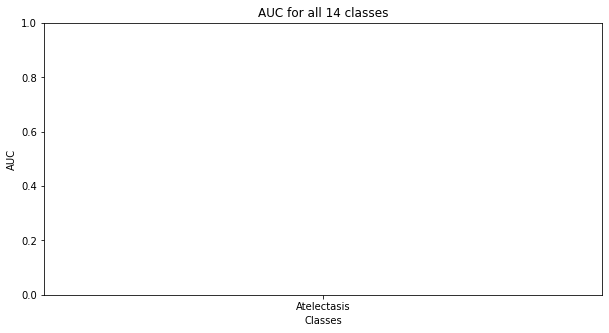

In [92]:
print("Evaluating the model on training data:")
evaluate_and_plot(trainingDF)

SQLContext(sc).clearCache()

### Evaluate the model and plot AUC accuracy for Validation Data

Evaluating the model on validation data:
22-04-06 12:00:30 [Thread-4] INFO  NNModel:730 - Batch per thread: 2; Total number of cores: 6; Global batch size: 12
22-04-06 12:00:30 [Executor task launch worker for task 0.0 in stage 1154.0 (TID 760)] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 2969
ROC score for                Atelectasis  is:  0.0                 
ROC score for               Cardiomegaly  is:  0.7037037037037037  
ROC score for                   Effusion  is:  0.5                 
ROC score for               Infiltration  is:  0.6818181818181818  
ROC score for                       Mass  is:  0.0                 
ROC score for                     Nodule  is:  0.0                 
ROC score for                  Pneumonia  is:  0.0                 
ROC score for               Pneumothorax  is:  0.0                 
ROC score for              Consolidation  is:  0.0                 
ROC score for                      Edema  is:  0.0                 
ROC score for  

NameError: name 'length' is not defined

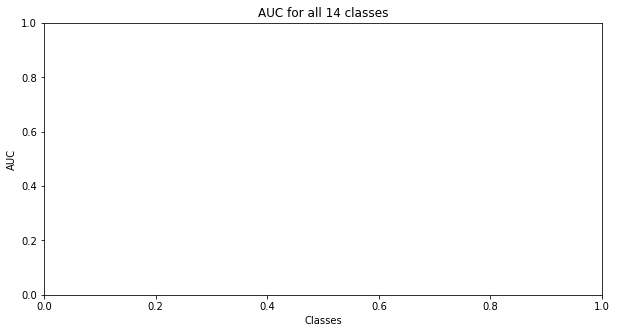

In [90]:
print("Evaluating the model on validation data:")
evaluate_and_plot(validationDF)

### Save the model for inference

In [97]:
model_path = save_path + '/xray_model_classif'
nnModel.model.saveModel(model_path + ".bigdl", model_path + ".bin", True)
print('Model saved at: ', model_path)

Model saved at:  /opt/application/data/model/xray_model_classif
